In [359]:
!pip install plotly

     |████████████████████████████████| 25.3 MB 36.4 MB/s            


# Insurance Analysis

Written by Aiswarya Sriram (as14988@nyu.edu), Reuben Cherian (rc4610@nyu.edu) , Sindhu Bhoopalam Dinesh (sb8019@nyu.edu)

In [1]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import StructType,StructField, StringType, FloatType, IntegerType
from pyspark.sql.window import Window


In [2]:
spark = pyspark.sql.SparkSession.builder\
        .master('local[*]')\
        .appName('insurance_analysis')\
        .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/16 20:10:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import pandas as pd
pd.set_option('display.max_rows',10)

## Part I - Rate vs State Analysis

In [4]:
rate_data = spark.read\
        .option("InferSchema","true")\
        .option("header","true")\
        .format("csv")\
        .load("data/Rate.csv")

In [27]:
rs_data = rate_data.select("IndividualRate","StateCode")

In [28]:
rs_data.show()

+--------------+---------+
|IndividualRate|StateCode|
+--------------+---------+
|          29.0|       AK|
|         36.95|       AK|
|         36.95|       AK|
|          32.0|       AK|
|          32.0|       AK|
|         36.95|       AK|
|         32.45|       AK|
|          32.0|       AK|
|          32.0|       AK|
|         32.45|       AK|
|         32.45|       AK|
|          32.0|       AK|
|          32.0|       AK|
|          32.0|       AK|
|          32.0|       AK|
|          32.0|       AK|
|          32.0|       AK|
|          32.0|       AK|
|          32.0|       AK|
|          32.0|       AK|
+--------------+---------+
only showing top 20 rows



To find understand the dependence of Individual Rate and State Code we can use coorelation ratio which will compare the intra category dispersion to the overall dispersion.<br>
Correlation ratio is defined as $ \eta^2 = \frac{\sum_{x}n_x(\bar{y_{x}}-\bar{y})^2}{\sum_{x,i}(y_{xi}-\bar{y})^2}$ or the ratio between the weighted variance of the category means and the overall variance <br> 
When correlation ratio is 1 then we know that the dispersion is because of the difference between the states suggesting high dependence between Individual Rate and State.
When correlation ratio is 0 then we know that the intra category dispersion is all the same suggestion no depence between the two columns Individual Rate and State.

We can easily calculate the overall denominator by finding variance and frequency/count and multiplying the variance with $\text{(frequency)}^2$ as shown below

In [29]:
overall_variance = rs_data.select(variance(col('IndividualRate')).alias('variance')).collect()
overall_count = rs_data.select(count(col('IndividualRate')).alias('count')).collect()
overall_mean = rs_data.select(mean(col('IndividualRate')).alias('mean')).collect()

In [8]:
overall_denominator = overall_variance[0][0]*overall_count[0][0]

In [9]:
overall_denominator

4.758157944723991e+16

To find the numerator part we will use window functions to find the frequency and variance for each category (State).

In [10]:
groups = Window.partitionBy("StateCode").orderBy("IndividualRate")
windowspec = Window.partitionBy("StateCode")

In [11]:
state_stats = rs_data.withColumn("row",row_number().over(groups))\
  .withColumn("count",count(col("IndividualRate")).over(windowspec)) \
  .withColumn("mean", mean(col("IndividualRate")).over(windowspec)) \
  .where(col("row")==1).select("StateCode","count","mean")

In [12]:
state_stats = state_stats.withColumn("overall_mean",lit(overall_mean[0][0]))

In [13]:
num_part_udf = udf(lambda col1, col2, col3 : col3*(col1-col2)**2, FloatType())

In [14]:
state_stats = state_stats.withColumn("numerator_part",num_part_udf(col("mean"),col("overall_mean"),col("count")))

In [15]:
state_stats.show()

+---------+-------+------------------+----------------+--------------+
|StateCode|  count|              mean|    overall_mean|numerator_part|
+---------+-------+------------------+----------------+--------------+
|       AZ| 350032| 3976.503845019884|4098.02645859167|   5.1691837E9|
|       SC|1563770| 5681.339818381169|4098.02645859167| 3.92018552E12|
|       LA| 172060| 8716.849949721405|4098.02645859167| 3.67064724E12|
|       MI|1023190|3052.6028670669875|4098.02645859167| 1.11825505E12|
|       NH|  18176| 351.4294608274661|4098.02645859167| 2.55136317E11|
|       NJ| 173175| 422.0171524758388|4098.02645859167| 2.34012148E12|
|       NV|  32016|299.12199530425806|4098.02645859167| 4.62044496E11|
|       OR|  68402| 277.1508622554897|4098.02645859167|  9.9860696E11|
|       VA| 325316| 319.3265238660536|4098.02645859167|  4.6450485E12|
|       WY|  46134|12103.594558460136|4098.02645859167| 2.95668757E12|
|       DE|  15928|  359.123400929182|4098.02645859167| 2.22663819E11|
|     

In [16]:
overall_numerator = state_stats.select(sum(col("numerator_part"))).collect()
overall_numerator = overall_numerator[0][0]

In [17]:
overall_numerator

152617688230912.0

In [18]:
corr_ratio = overall_numerator/overall_denominator

In [19]:
corr_ratio

0.003207495211463918

From the above correlation ratio we can conclude that individual insurance rates aren't heavily affected by the state that the individual is from.

Despite the low correlation we can still plot a heatmap showing the average rates of insurance plans for each state which can be very insightful to insurance providers (its good to know which states people on average pays the most for their insurance plans.)

In [36]:
average_rates = [val.mean for val in state_stats.select('mean').collect()]
states = [val.StateCode for val in state_stats.select('StateCode').collect()]

In [37]:
import plotly.express as px
fig = px.choropleth(locations=states, locationmode="USA-states", color=average_rates, scope="usa", title="Average Annual Insurance Rate across States", labels={'color':'Avg. Annual Rate in USD'})
fig.show()

## Part II - Analysis of plan benefits across the states

In [39]:
ins = spark.read.option("header",True) \
.option("inferSchema", True) \
.csv("data/BenefitsCostSharing.csv")

In [55]:
ins.show(5)

+--------------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------------+----------+--------------------+-------------------+---------+-----+-----------------+-----------------+--------------+----------------+----------------+--------+---------+--------+--------------------+-----------+-----------------+---------------+---------+----------+-------------------+---------+----------+----------+
|         BenefitName|BusinessYear|CoinsInnTier1|CoinsInnTier2|CoinsOutofNet|CopayInnTier1|CopayInnTier2|CopayOutofNet|        EHBVarReason|Exclusions|         Explanation|         ImportDate|IsCovered|IsEHB|IsExclFromInnMOOP|IsExclFromOonMOOP|IsStateMandate|IsSubjToDedTier1|IsSubjToDedTier2|IssuerId|IssuerId2|LimitQty|           LimitUnit|MinimumStay|           PlanId|QuantLimitOnSvc|RowNumber|SourceName|StandardComponentId|StateCode|StateCode2|VersionNum|
+--------------------+------------+-------------+-------------+-------------

21/12/14 05:28:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [40]:
# Let us try to find out the count of each health insurance benefit per year
ins.createOrReplaceTempView ("Benefits")
benefits_per_year = spark.sql("SELECT BenefitName, BusinessYear, count(BenefitName) as count from Benefits GROUP BY BenefitName, BusinessYear")
benefits_per_year.show(5)

21/12/17 01:41:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------------+-----+
|         BenefitName|BusinessYear|count|
+--------------------+------------+-----+
|Non-Preferred Gen...|        2014|  213|
|Space Maintainers...|        2014|   32|
| Tissue Conditioning|        2014|   13|
|   Cochlear Implants|        2014|  742|
|     Enteral Formula|        2014|   12|
+--------------------+------------+-----+
only showing top 5 rows



In [41]:
benefits_per_year.createOrReplaceTempView ("benefits_per_year")
#Find out the top 5 health insurance benefits availed in the year 2014
benefits_2014 = spark.sql("SELECT BenefitName, count from benefits_per_year Where BusinessYear='2014' ORDER BY count DESC")
benefits_2014.show(5)

+--------------------+-----+
|         BenefitName|count|
+--------------------+-----+
| Orthodontia - Child|18719|
|Basic Dental Care...|18719|
|Major Dental Care...|18719|
| Orthodontia - Adult|18719|
|   Accidental Dental|18719|
+--------------------+-----+
only showing top 5 rows



In [42]:
#Find out the top 5 benefits in the year 2015
benefits_2015 = spark.sql("SELECT BenefitName, count from benefits_per_year where BusinessYear = '2015' ORDER BY count DESC")
benefits_2015.show(5)

+--------------------+-----+
|         BenefitName|count|
+--------------------+-----+
| Orthodontia - Adult|31269|
|Major Dental Care...|31253|
|Dental Check-Up f...|31253|
|Routine Dental Se...|31253|
|   Accidental Dental|31253|
+--------------------+-----+
only showing top 5 rows



In [43]:
#Find out the top 5 benefits in the year 2016
benefits_2016 = spark.sql("SELECT BenefitName, count from benefits_per_year where BusinessYear = '2016' ORDER BY count DESC")
benefits_2016.show(5)

+--------------------+-----+
|         BenefitName|count|
+--------------------+-----+
| Orthodontia - Adult|27389|
|Routine Dental Se...|27381|
|   Accidental Dental|27381|
|Dental Check-Up f...|27381|
|Basic Dental Care...|27381|
+--------------------+-----+
only showing top 5 rows



In [44]:
#Next we want to find out which is the benefit that is most needed per state
#Let us first explore the list of distinct states
#We need to find for each state code, which is the maximum benefit name
states = ins.select('StateCode').filter(ins.StateCode != "None").distinct().collect()
states

[Row(StateCode='AZ'),
 Row(StateCode='SC'),
 Row(StateCode='LA'),
 Row(StateCode='NJ'),
 Row(StateCode='NC'),
 Row(StateCode='MO'),
 Row(StateCode='ND'),
 Row(StateCode='MS'),
 Row(StateCode='AL'),
 Row(StateCode='IN'),
 Row(StateCode='TN'),
 Row(StateCode='PA'),
 Row(StateCode='HIOS'),
 Row(StateCode='GA'),
 Row(StateCode='FL'),
 Row(StateCode='AK'),
 Row(StateCode='OK'),
 Row(StateCode='VA'),
 Row(StateCode='WY'),
 Row(StateCode='NH'),
 Row(StateCode='MI'),
 Row(StateCode='WI'),
 Row(StateCode='ID'),
 Row(StateCode='NE'),
 Row(StateCode='MT'),
 Row(StateCode='DE'),
 Row(StateCode='IL'),
 Row(StateCode='ME'),
 Row(StateCode='OH'),
 Row(StateCode='NM'),
 Row(StateCode='IA'),
 Row(StateCode='No'),
 Row(StateCode='TX'),
 Row(StateCode='WV'),
 Row(StateCode='KS'),
 Row(StateCode='AR'),
 Row(StateCode='89942GA0050003'),
 Row(StateCode='89942GA0050002'),
 Row(StateCode='89942GA0050005'),
 Row(StateCode='89942GA0050004'),
 Row(StateCode='89942GA0050012'),
 Row(StateCode='SD'),
 Row(StateCode

In [45]:
#From above, we can see that the states contain some values with numbers as well as some wrong values like 
#HIOS-which is an insurance source name and not a state code. We need to filter these out
benefits_per_state_c = spark.sql("SELECT * from Benefits WHERE StateCode != 'None' and StateCode REGEXP '^[A-Z]' and CHAR_LENGTH(StateCode) == 2")
benefits_per_state_c= benefits_per_state_c.filter(col("StateCode")!='No')
benefits_per_state_c.createOrReplaceTempView ("benefits_per_state_c")
#Let us understand which benefit name is used most by the population of each state
#For this we can group by statecode
#we get the benefit names and their count per state
benefits_per_state = spark.sql("SELECT StateCode, BenefitName, count(BenefitName) as count from benefits_per_state_c GROUP BY BenefitName, StateCode")
benefits_per_state.show(60)

+---------+--------------------+-----+
|StateCode|         BenefitName|count|
+---------+--------------------+-----+
|       AZ|     Specialty Drugs| 2886|
|       FL|Nutritional Couns...| 4669|
|       GA|Dental Check-Up f...| 2893|
|       LA|Rehabilitative Oc...| 1157|
|       LA|    Infusion Therapy| 1157|
|       LA|Preventive Care/S...| 1157|
|       MO|Periodontal Root ...|    3|
|       ND|   Routine Foot Care|  636|
|       OK|Preferred Brand D...| 1787|
|       AL|Inpatient Physici...|  360|
|       NC|        Chemotherapy| 1221|
|       ND|Private-Duty Nursing|  636|
|       OK|   Chiropractic Care| 1787|
|       MO|Primary Care Visi...| 1219|
|       ND|Rehabilitative Oc...|  636|
|       ND|        Chemotherapy|  636|
|       NJ|Outpatient Facili...|  988|
|       PA|Cast metal, stain...|   16|
|       AZ|        Hearing Aids| 2886|
|       FL|    Hospice Services| 4669|
|       ND|Laboratory Outpat...|  636|
|       NJ|Outpatient Surger...|  988|
|       OK|            Di

In [46]:
#From the above we can see that for state AZ the count of the benefits is 2886, so 2886 people have 
#opted for an insurance plan which provides the benefit of Specialty Drugs
#How can we find out which benefit name in state AZ was availed the most?
#And similarly find out the most frequent benefit used in each state?
#We will do this in the later sections of the notebook

In [47]:
#Next let us try to find out the which state uses the maximum number of benefits
#This would tell us which state has a large number of people who avail insurance benefits
#Total frequency of benefits used per state
benefits_per_state.createOrReplaceTempView ("benefits_per_state")
tot_benefits = spark.sql("SELECT StateCode, sum(count) as tot_benefits from benefits_per_state GROUP BY StateCode")
tot_benefits.show(60)

+---------+------------+
|StateCode|tot_benefits|
+---------+------------+
|       AZ|      221612|
|       SC|      111907|
|       LA|       91816|
|       NJ|       86107|
|       OR|       93331|
|       VA|      142236|
|       WY|       48425|
|       NH|       44305|
|       MI|      189225|
|       NV|       62683|
|       WI|      512180|
|       ID|       27313|
|       NE|       66935|
|       MT|       58132|
|       NC|       94290|
|       DE|       31370|
|       MO|       95152|
|       IL|      320533|
|       ME|       61834|
|       ND|       48269|
|       MS|       46895|
|       AL|       28417|
|       IN|      148531|
|       OH|      330951|
|       TN|      137683|
|       IA|      110221|
|       NM|       56669|
|       PA|      260866|
|       SD|       47730|
|       TX|      465164|
|       WV|       32638|
|       GA|      196537|
|       KS|       64279|
|       FL|      363243|
|       AK|       41320|
|       AR|       68064|
|       OK|      133639|


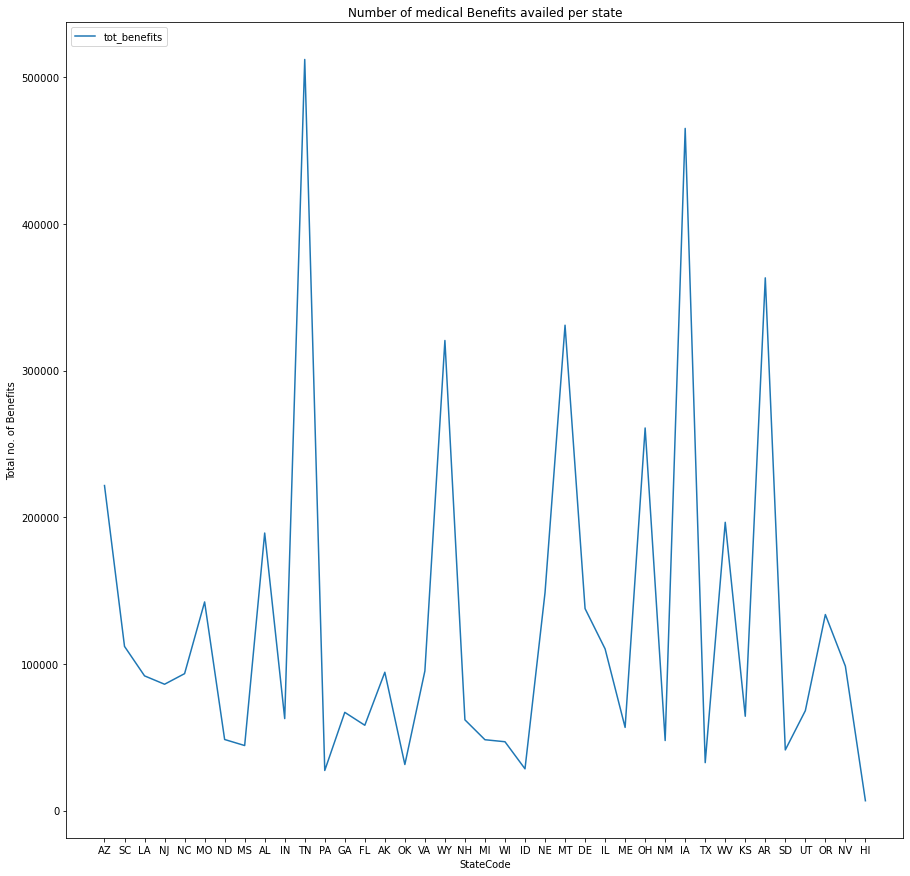

In [48]:
#Let us plot the benefit_count on the y axis and each state on the x-axis
import matplotlib.pyplot as plt

y_benefits = [val.tot_benefits for val in tot_benefits.select('tot_benefits').collect()]
x_state = [val.StateCode for val in tot_benefits.select('StateCode').collect()]

plt.figure(figsize=(15, 15))
plt.plot(x_state, y_benefits)

plt.ylabel('Total no. of Benefits')
plt.xlabel('StateCode')
plt.title('Number of medical Benefits availed per state')
plt.legend(['tot_benefits'], loc='upper left')

plt.show()

In [49]:
#This is difficult to read so let us sort in decreasing order from 
#the state which used maximum number of benefits to least
tot_benefits.createOrReplaceTempView ("tot_benefits")
tot_benefits_sort = spark.sql("SELECT * from tot_benefits ORDER BY tot_benefits DESC")
tot_benefits_sort.show(5)

+---------+------------+
|StateCode|tot_benefits|
+---------+------------+
|       WI|      512180|
|       TX|      465164|
|       FL|      363243|
|       OH|      330951|
|       IL|      320533|
+---------+------------+
only showing top 5 rows



/tmp/ipykernel_31/2596573392.py:8: UserWarning:                                 

FixedFormatter should only be used together with FixedLocator



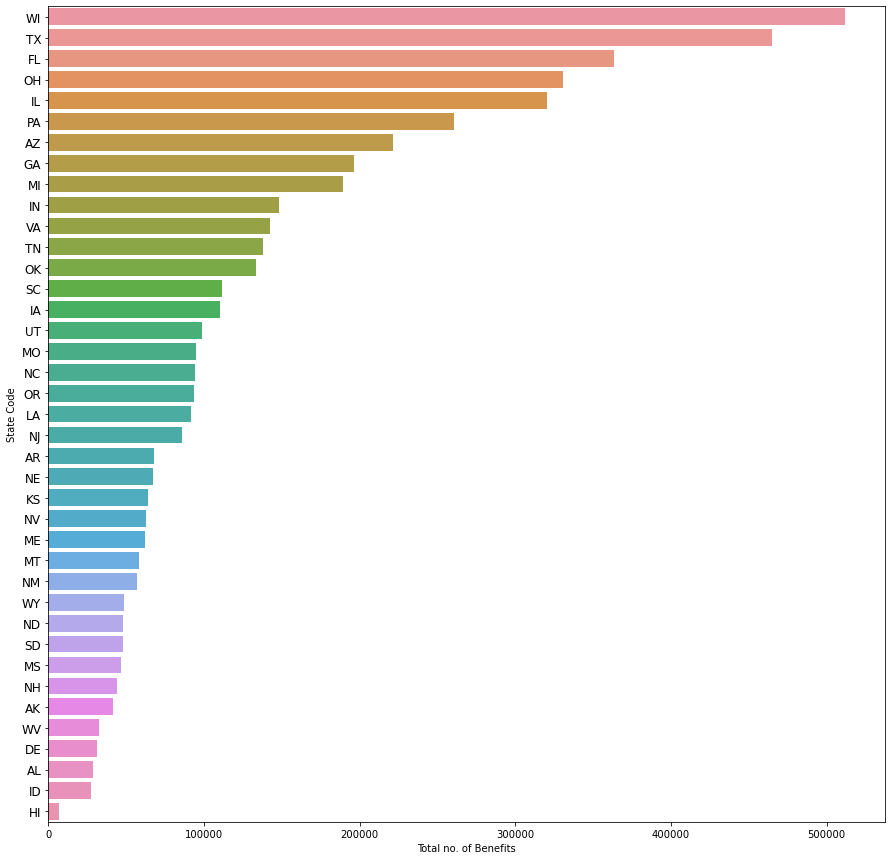

In [50]:
#We can see that state WI(Wisconsin) is using maximum number of benefits, followed by TX(Texas) and the FL(Florida)
#Let's try to visualize this
import seaborn as sns
f, ax = plt.subplots(figsize=(15, 15)) 
x_benefits = [val.tot_benefits for val in tot_benefits_sort.select('tot_benefits').collect()]
y_state = [val.StateCode for val in tot_benefits_sort.select('StateCode').collect()]

ax.set_yticklabels(y_state, rotation='horizontal', fontsize='large')
g = sns.barplot(y = y_state, x= x_benefits)
plt.ylabel('State Code')
plt.xlabel('Total no. of Benefits')
plt.show()

In [67]:
#Now we want to find the top benefit used in each state
#We can get an idea of which healthcare service is most needed in each state from this
window = Window.partitionBy("StateCode").orderBy(col("count").desc())
step1 = benefits_per_state.withColumn("row",row_number().over(window)) \
  .filter(col("row") <=1 )\
  .drop("row")
step1.show()

+---------+--------------------+-----+
|StateCode|         BenefitName|count|
+---------+--------------------+-----+
|       AK| Orthodontia - Child|  720|
|       AL| Orthodontia - Adult|  653|
|       AR| Orthodontia - Adult| 1077|
|       AZ|   Accidental Dental| 3345|
|       DE|Dental Check-Up f...|  602|
|       FL|Basic Dental Care...| 5130|
|       GA|Dental Check-Up f...| 2893|
|       HI| Orthodontia - Child|  110|
|       IA|Major Dental Care...| 1727|
|       ID|Basic Dental Care...|  447|
|       IL| Orthodontia - Adult| 4299|
|       IN|Routine Dental Se...| 2347|
|       KS|Routine Dental Se...| 1087|
|       LA| Orthodontia - Child| 1491|
|       ME|Major Dental Care...|  975|
|       MI| Orthodontia - Adult| 3248|
|       MO|   Accidental Dental| 1577|
|       MS|   Accidental Dental|  725|
|       MT|Major Dental Care...| 1049|
|       NC|Routine Dental Se...| 1537|
+---------+--------------------+-----+
only showing top 20 rows



In [68]:
#Thus we can see that in most of the states the maximum used benefit is related to dental care/Orthodontia
#Thus dental care is the most sought after benefit and we can use this information to maximise profits
#If we inform insurance providers about this, they can design their plans accordingly

## Part III - Effect of Age and Health Habits on Plan Rates

In [52]:
#Read the Plan Rates CSV
df = spark.read\
.option("inferSchema", "true")\
.option("header", True)\
.csv("data/rate.csv")

In [53]:
#Compute Average Individual Plan Rate for each age group
age_df = df.groupBy('Age')\
        .agg(avg('IndividualRate').alias('Average_Individuale_Rate'))\
        .orderBy('Age')
age_df.show(50)

+-------------+------------------------+
|          Age|Average_Individuale_Rate|
+-------------+------------------------+
|         0-20|      122.25594318419256|
|           21|      4082.8390381688987|
|           22|      4082.9056272181106|
|           23|      4082.9846245389685|
|           24|      4083.0777823621565|
|           25|      4083.6237581046585|
|           26|      4087.1409880443484|
|           27|       4091.294936709168|
|           28|        4097.99116228603|
|           29|       4103.554396576272|
|           30|       4106.364008482652|
|           31|      4110.5454047511475|
|           32|      4114.7269729050495|
|           33|       4117.351338035569|
|           34|       4120.145217556796|
|           35|       4121.613227202191|
|           36|       4123.018255064925|
|           37|       4124.441329694502|
|           38|       4125.875227832506|
|           39|      4128.6927322160045|
|           40|       4131.558551592119|
|           41| 

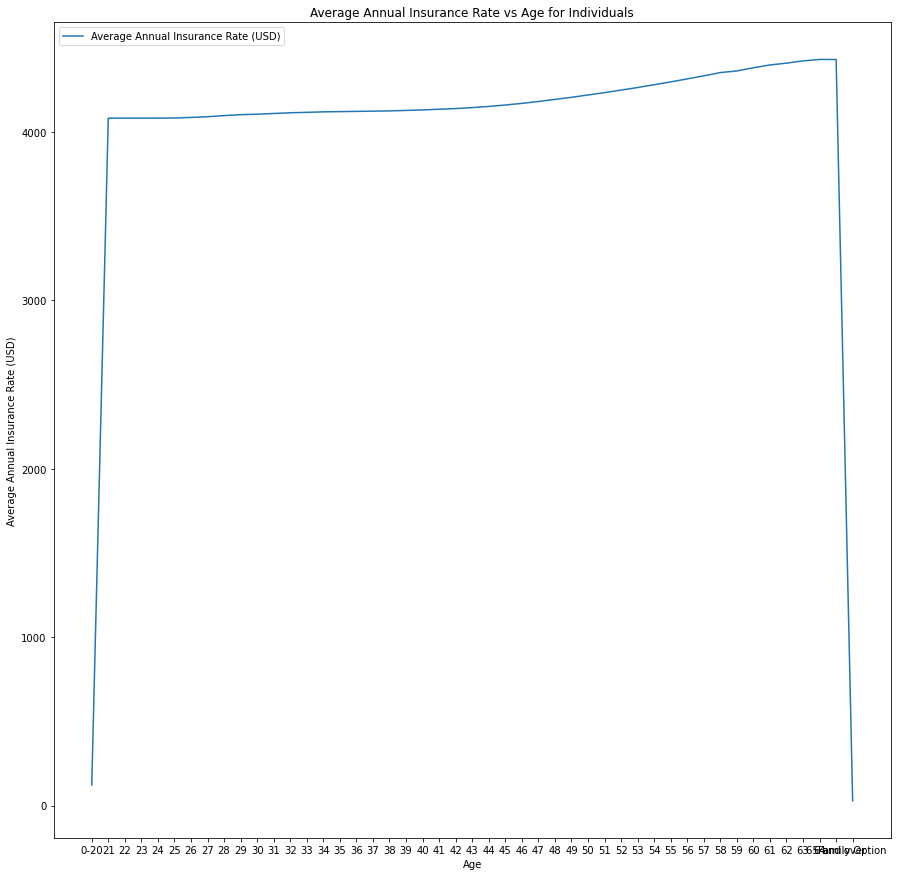

In [54]:
#Rates look oddly same for many age categories
import matplotlib.pyplot as plt

y_avg_rate = [val.Average_Individuale_Rate for val in age_df.select('Average_Individuale_Rate').collect()]
x_age = [val.Age for val in age_df.select('Age').collect()]

plt.figure( figsize=(15,15))
plt.plot(x_age, y_avg_rate)

plt.ylabel('Average Annual Insurance Rate (USD)')
plt.xlabel('Age')
plt.title('Average Annual Insurance Rate vs Age for Individuals')
plt.legend(['Average Annual Insurance Rate (USD)'], loc='upper left')

plt.show()

In [57]:
#Reading Plan Attributes CSV to perform further analysis on Plan Rates and Age 
plan_df = spark.read\
.option("inferSchema", "true")\
.option("header", True)\
.csv("data/PlanAttributes.csv")

In [58]:
#Select and pre-process required columns - remove state code from the plsn ID to comvbine the 2 datasets on plan ID
plan_df = plan_df.withColumn('planid', substring('planid', 1,14))\
                 .select('planid', 'dentalonlyplan')
plan_df.show()

+--------------+--------------+
|        planid|dentalonlyplan|
+--------------+--------------+
|21989AK0020002|           Yes|
|21989AK0020002|           Yes|
|21989AK0020001|           Yes|
|21989AK0010001|           Yes|
|21989AK0010001|           Yes|
|21989AK0020001|           Yes|
|73836AK0650002|            No|
|73836AK0680004|            No|
|73836AK0680004|            No|
|73836AK0650002|            No|
|73836AK0650002|            No|
|73836AK0630001|            No|
|73836AK0680038|            No|
|73836AK0630001|            No|
|42507AK0020001|           Yes|
|42507AK0020001|           Yes|
|42507AK0030001|           Yes|
|73836AK0630001|            No|
|73836AK0680038|            No|
|73836AK0630002|            No|
+--------------+--------------+
only showing top 20 rows



In [59]:
#Checking Non-Dental Plans and dental plan separately to see how the average rate looks like
#Start with non-dental plans
med_avg = df.join(plan_df, ['planid'])\
        .select(col('Age'), col('IndividualRate'), col('dentalonlyplan'),col('statecode'))\
        .filter(col('dentalonlyplan') == 'No')\
        .groupBy('age')\
        .agg(avg(col('IndividualRate')).alias('med_rate_avg'))\
        .orderBy(col('Age'))
med_avg.show()

+----+------------------+
| age|      med_rate_avg|
+----+------------------+
|0-20|175.31748656568496|
|  21| 275.4203831270852|
|  22|   275.60526800108|
|  23| 275.8383278532004|
|  24|276.12688143096557|
|  25|277.58946304176663|
|  26|283.17313377564005|
|  27| 289.6860629080482|
|  28|300.10899978213513|
|  29|308.74581562017903|
|  30| 313.0673360634101|
|  31|319.54508890794705|
|  32| 326.0230255355301|
|  33|330.07205729040777|
|  34|334.38881782872187|
|  35|336.54944131530016|
|  36|338.70487261002853|
|  37|340.91404514665606|
|  38| 343.1527391717487|
|  39|347.56163506291915|
+----+------------------+
only showing top 20 rows



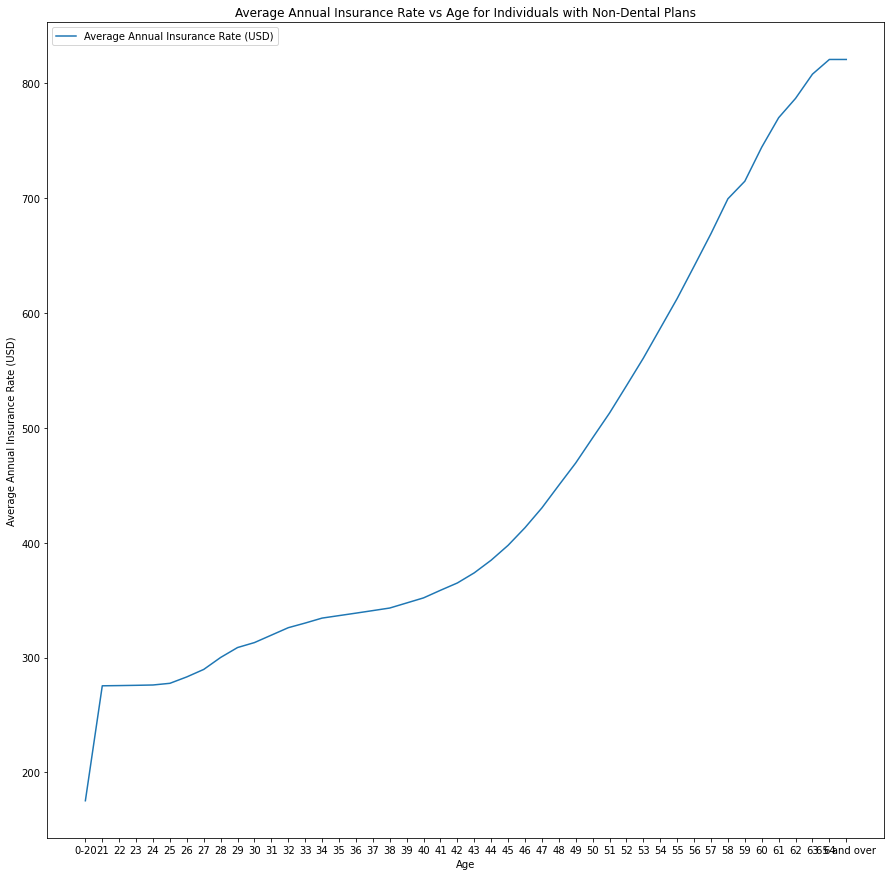

In [60]:
#Rates increase with age for non-dental plans
import matplotlib.pyplot as plt

y_avg_rate = [val.med_rate_avg for val in med_avg.select('med_rate_avg').collect()]
x_age = [val.age for val in med_avg.select('age').collect()]

plt.figure( figsize=(15,15))
plt.plot(x_age, y_avg_rate)

plt.ylabel('Average Annual Insurance Rate (USD)')
plt.xlabel('Age')
plt.title('Average Annual Insurance Rate vs Age for Individuals with Non-Dental Plans')
plt.legend(['Average Annual Insurance Rate (USD)'], loc='upper left')

plt.show()

In [61]:
#Check the individual rates state-wise
med = df.join(plan_df, ['planid'])\
        .select(col('Age') ,col('statecode'), col('IndividualRate'), col('dentalonlyplan'))\
        .filter(col('dentalonlyplan') == 'No')\
        .orderBy(col('Age'), col('statecode'))
med.show()

+----+---------+--------------+--------------+
| Age|statecode|IndividualRate|dentalonlyplan|
+----+---------+--------------+--------------+
|0-20|       AK|         259.0|            No|
|0-20|       AK|         360.0|            No|
|0-20|       AK|         259.0|            No|
|0-20|       AK|         264.0|            No|
|0-20|       AK|         367.0|            No|
|0-20|       AK|         353.0|            No|
|0-20|       AK|         259.0|            No|
|0-20|       AK|         264.0|            No|
|0-20|       AK|         264.0|            No|
|0-20|       AK|         373.0|            No|
|0-20|       AK|         367.0|            No|
|0-20|       AK|         360.0|            No|
|0-20|       AK|         353.0|            No|
|0-20|       AK|         259.0|            No|
|0-20|       AK|         259.0|            No|
|0-20|       AK|         264.0|            No|
|0-20|       AK|         366.0|            No|
|0-20|       AK|         264.0|            No|
|0-20|       

In [78]:
#Find out correlation between age and plan rates for non-dental plans
#substring of 0-20 to 20
#convert string to int using cast
med = med.withColumn("Age", when(med.Age == "0-20","20")
                           .when(med.Age == "65 and over", "65" )
                           .otherwise(med.Age))\
         .filter( med.Age != "Family Option" )

med = med.withColumn( "Age", col("Age").cast("integer"))

In [79]:
med.stat.corr("Age", "IndividualRate")
#We get a good correlation

0.7599402192775833

In [80]:
med_avg = med_avg.withColumn("age", when(med_avg.age == "0-20","20") 
                           .when(med_avg.age == "65 and over", "65" )
                           .otherwise(med_avg.age))\
         .filter( med_avg.age != "Family Option" )
med_avg = med_avg.withColumn( "age", col("age").cast("integer"))

med_avg.stat.corr("age", "med_rate_avg" )

0.9442173992842794

In [62]:
#Checking Dental Plans
den_avg = df.join(plan_df, ['planid'])\
        .select(col('Age'), col('IndividualRate'), col('dentalonlyplan'),col('statecode'))\
        .filter(col('dentalonlyplan') == 'Yes')\
        .groupBy('age')\
        .agg(avg(col('IndividualRate')).alias('den_rate_avg'))\
        .orderBy(col('Age'))
den_avg.show()

+----+-----------------+
| age|     den_rate_avg|
+----+-----------------+
|0-20|27.42485717755229|
|  21|9735.999907165442|
|  22|9736.057686851002|
|  23|9736.116937220746|
|  24|9736.176907180658|
|  25|9735.668956190291|
|  26| 9735.82599795673|
|  27|9735.895462602337|
|  28|  9735.9587485933|
|  29| 9736.02201152818|
|  30|9736.108019762509|
|  31|9736.172372405787|
|  32|9736.237752573245|
|  33|9736.304284298334|
|  34|9736.370881684665|
|  35|9736.559496058246|
|  36|9736.628133518403|
|  37|9736.696735113417|
|  38| 9736.76725027833|
|  39|9736.838678723381|
+----+-----------------+
only showing top 20 rows



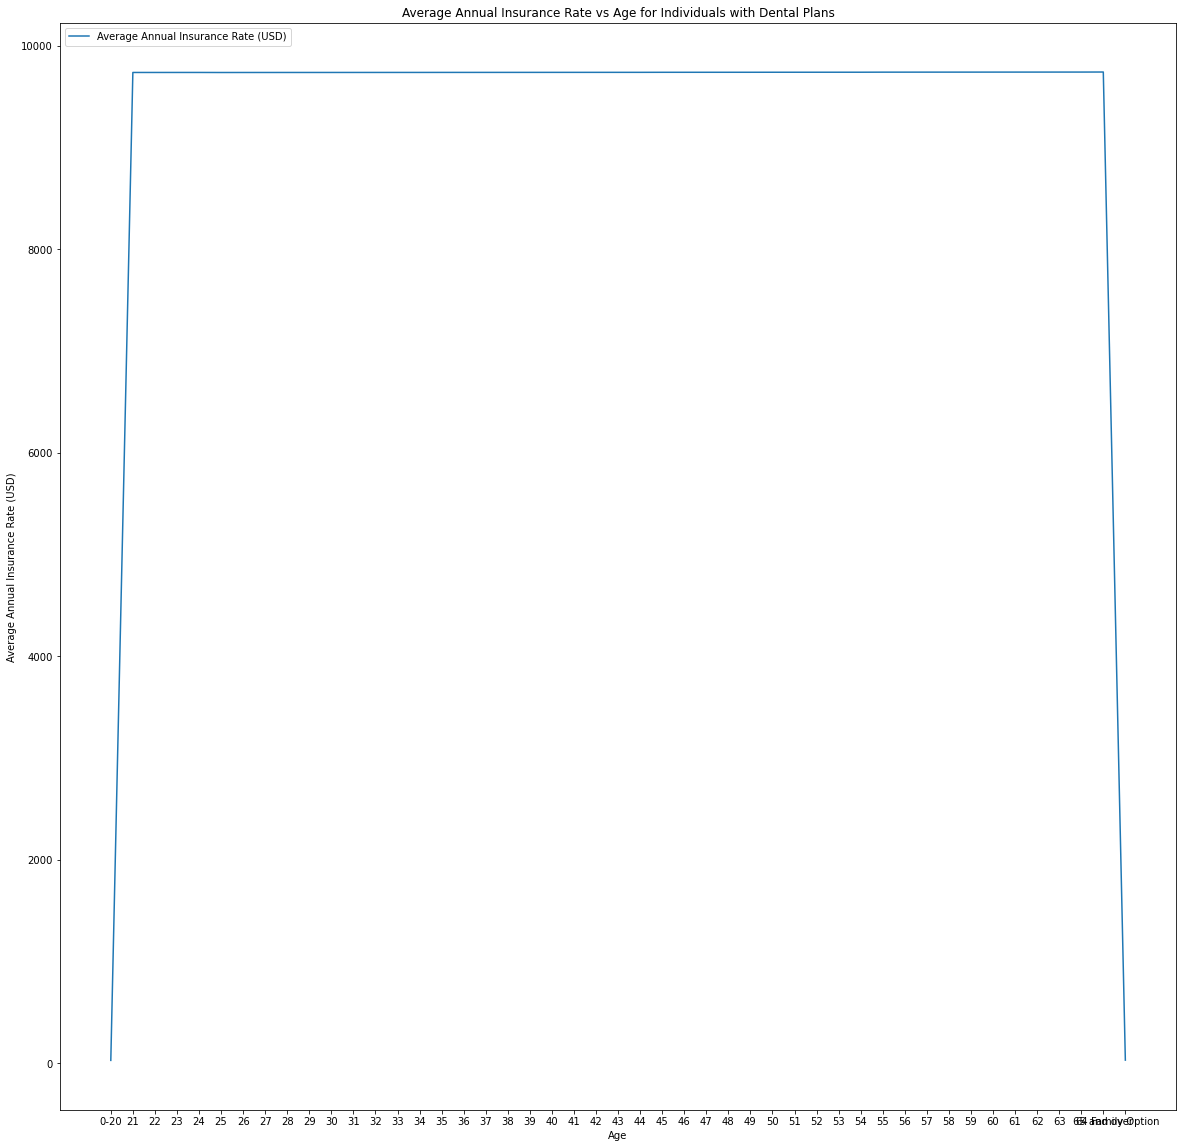

In [64]:
import matplotlib.pyplot as plt

y_avg_rate = [val.den_rate_avg for val in den_avg.select('den_rate_avg').collect()]
x_age = [val.age for val in den_avg.select('age').collect()]

plt.figure( figsize=(20,20))
plt.plot(x_age, y_avg_rate)

plt.ylabel('Average Annual Insurance Rate (USD)')
plt.xlabel('Age')
plt.title('Average Annual Insurance Rate vs Age for Individuals with Dental Plans')
plt.legend(['Average Annual Insurance Rate (USD)'], loc='upper left')

plt.show()

In [83]:
den = df.join(plan_df, ['planid'])\
        .select(col('Age') ,col('statecode'), col('IndividualRate'), col('dentalonlyplan'))\
        .filter(col('dentalonlyplan') == 'Yes')\
        .orderBy(col('Age'), col('statecode'))
den.show()

+----+---------+--------------+--------------+
| Age|statecode|IndividualRate|dentalonlyplan|
+----+---------+--------------+--------------+
|0-20|       AK|         33.55|           Yes|
|0-20|       AK|          43.0|           Yes|
|0-20|       AK|         33.55|           Yes|
|0-20|       AK|          43.0|           Yes|
|0-20|       AK|          43.0|           Yes|
|0-20|       AK|         33.55|           Yes|
|0-20|       AK|         33.55|           Yes|
|0-20|       AK|          43.0|           Yes|
|0-20|       AK|          43.0|           Yes|
|0-20|       AK|          43.0|           Yes|
|0-20|       AK|          43.0|           Yes|
|0-20|       AK|          43.0|           Yes|
|0-20|       AK|         33.55|           Yes|
|0-20|       AK|         33.55|           Yes|
|0-20|       AK|         33.55|           Yes|
|0-20|       AK|          43.0|           Yes|
|0-20|       AK|         33.55|           Yes|
|0-20|       AK|          43.0|           Yes|
|0-20|       

In [84]:
#Find correlation between age and plan rates for dental plans
den = den.withColumn("Age", when(den.Age == "0-20","20") 
                           .when(den.Age == "65 and over", "65" )
                           .otherwise(den.Age))\
         .filter( den.Age != "Family Option" )

den = den.withColumn( "Age", col("Age").cast("integer"))
den.stat.corr("Age", "IndividualRate")
#We can see that the correlation of dental plans with age is not very great, thus plan rates not age dependent

0.003742359055674814

In [85]:
den_avg = den_avg.withColumn("age", when(den_avg.age == "0-20","20") 
                           .when(den_avg.age == "65 and over", "65" ) 
                           .otherwise(den_avg.age))\
         .filter( den_avg.age != "Family Option" )
den_avg = den_avg.withColumn( "age", col("age").cast("integer"))

den_avg.stat.corr("age", "den_rate_avg" )

0.2535548581000786

Analysing based on Health Habits

In [ ]:
hdf = df.select(col('Age'), col('Tobacco'), col('IndividualRate'), col('IndividualTobaccoRate'))
hdf.show()

In [ ]:
#Encode No Preference for Tobacco as 0 and a preference as 1
#Fill IndividualTobaccoRate as 0 when there is no preference
hdfp = hdf.withColumn("Tobacco", when(hdf.Tobacco == "No Preference",0) \
      .otherwise(1))
hdfp = hdfp.na.fill(0)
hdfp.show()

+-------------+-------+--------------+---------------------+
|          Age|Tobacco|IndividualRate|IndividualTobaccoRate|
+-------------+-------+--------------+---------------------+
|         0-20|      0|          29.0|                  0.0|
|Family Option|      0|         36.95|                  0.0|
|Family Option|      0|         36.95|                  0.0|
|           21|      0|          32.0|                  0.0|
|           22|      0|          32.0|                  0.0|
|Family Option|      0|         36.95|                  0.0|
|Family Option|      0|         32.45|                  0.0|
|           23|      0|          32.0|                  0.0|
|           24|      0|          32.0|                  0.0|
|Family Option|      0|         32.45|                  0.0|
|Family Option|      0|         32.45|                  0.0|
|           25|      0|          32.0|                  0.0|
|           26|      0|          32.0|                  0.0|
|           27|      0| 

In [ ]:
tb = hdfp.filter(col('IndividualTobaccoRate') != 0)
tb.show()

+----+-------+--------------+---------------------+
| Age|Tobacco|IndividualRate|IndividualTobaccoRate|
+----+-------+--------------+---------------------+
|0-20|      1|        111.74|               111.74|
|  21|      1|        175.99|               193.59|
|  22|      1|        175.99|               193.59|
|  23|      1|        175.99|               193.59|
|  24|      1|        175.99|               193.59|
|  25|      1|         176.7|               194.37|
|  26|      1|         180.2|               198.22|
|  27|      1|        184.43|               202.87|
|  28|      1|         191.3|               210.43|
|  29|      1|        196.93|               216.62|
|  30|      1|        199.74|               219.71|
|  31|      1|        203.97|               224.36|
|  32|      1|         208.2|               229.01|
|  33|      1|        210.82|                231.9|
|  34|      1|        213.65|               235.02|
|  35|      1|        215.05|               236.55|
|  36|      

In [ ]:
tb.stat.corr('IndividualTobaccoRate', 'IndividualRate')
#We have a good correlation with IndividualTobaccoRate and IndividualRate

0.9737016662122226

## Part IV - Distribution of Rates across Insurance Issuers

In [47]:
groups = Window.partitionBy("IssuerId").orderBy("IndividualRate")
windowspec = Window.partitionBy("IssuerId")

In [48]:
ipdata = rate_data.select("IssuerId","IndividualRate")

In [49]:
ipdata_stats = ipdata.withColumn("row",row_number().over(groups))\
  .withColumn("count",count(col("IndividualRate")).over(windowspec)) \
  .withColumn("mean", mean(col("IndividualRate")).over(windowspec)) \
  .withColumn("stddev",stddev(col("IndividualRate")).over(windowspec))\
  .where(col("row")==1).select("IssuerId","count","mean","stddev")

In [50]:
ipdata_stats.show()

+--------+------+------------------+------------------+
|IssuerId| count|              mean|            stddev|
+--------+------+------------------+------------------+
|   10739|   736|19.971249999999916|1.2289627560598946|
|   11103|  3212| 72.67022415940018| 39.17536515406607|
|   12530|    20|            31.425| 4.568093579094941|
|   13285|  1288|0.3670108695652174|2.6768842700750355|
|   15438|  6486|380.50515726179424|  180.876982136986|
|   15614| 10902|19.740659512014798| 7.740719660597932|
|   16204| 26588|  526.804486986609|244.19828136414532|
|   16698|  2576|452.08496894409996|205.46164595023956|
|   16724|  3220| 404.4502950310556|170.74374396142105|
|   18973| 12834| 324.8096330060759|160.46629117946128|
|   20069|  1104|370.34895833333303|179.07184226759813|
|   20129|136528| 496.1959869770377|229.92480209549302|
|   23499|    98| 32.85142857142859|5.8234617897342575|
|   24106|  2576| 32.95595108695577| 6.207346523440822|
|   25440|  1288|0.7023913043478263| 4.935427013

With the above information we have have effectively calculated the dispersion (using standard deviation) of plan rates across each of the issuers which tells us how the data is distributed in each of the issuerid groups.

In [51]:
ipdata_stats.sort(col("stddev").desc()).show(5)

+--------+-----+------------------+------------------+
|IssuerId|count|              mean|            stddev|
+--------+-----+------------------+------------------+
|   17859| 3864|326112.38229813665| 468821.8232593795|
|   26075| 2320|193988.10149568965|395475.86620604934|
|   26904| 7140| 176490.6838739496|  381236.974109308|
|   11324| 3336| 161892.2988399281|368377.17377564113|
|   42757| 3336|161897.17219424463| 368375.0318917477|
+--------+-----+------------------+------------------+
only showing top 5 rows




[Stage 60:=================================================>        (6 + 1) / 7]



The above statistics shows us issuers which have a very diverse portfolio based on standard deviation

## Part V - Predicting Individual Insurance Rate

In [7]:
rate = spark.read\
        .option("InferSchema","true")\
        .option("header","true")\
        .format("csv")\
        .load("data/Rate.csv")

Below we are filtering the million dollar dataset form the Rate table

In [8]:
rate = rate.filter(col("IndividualRate")!= 99999)

Below we are filtering all the null values from the individual tobacco rate from the rate table

In [9]:
rate = rate.where(col("IndividualTobaccoRate").isNotNull())

The age column here is filtered to exclude any non numerical groups and they are cast to integers

In [10]:
rate = rate.withColumn("Age", when(rate.Age == "0-20","20")
                           .when(rate.Age == "65 and over", "65" )
                           .otherwise(rate.Age))\
         .filter( rate.Age != "Family Option" )
rate = rate.withColumn( "Age", col("Age").cast("integer"))

Filtering out all the rows where age is null

In [11]:
rate = rate.where(col("Age").isNotNull())

In [12]:
features = ["Age","IndividualTobaccoRate"]
label = ["IndividualRate"]
all_columns = features+label

In [13]:
rate = rate.select(all_columns)

In [14]:
for column in rate.columns:
    if (rate.where(col(column).isNull()).count() >0):
        print(column)

The pipeline includes a vector assembler which will convert all the feature fields into a vector which builds the feature vector for the linear regression model

In [15]:
from pyspark.ml.feature import VectorAssembler

stages = []
assembler = VectorAssembler(inputCols=features, outputCol="features")
stages += [assembler]

In [16]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(rate)
rate = pipelineModel.transform(rate)
selectedCols = ['features'] + all_columns
df = rate.select(selectedCols)
df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Age: integer (nullable = true)
 |-- IndividualTobaccoRate: double (nullable = true)
 |-- IndividualRate: double (nullable = true)



In [17]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 3452226


Test Dataset Count: 1480123



[Stage 16:====================================================>   (14 + 1) / 15]



In [18]:
train.select("features").show()

+------------+
|    features|
+------------+
| [20.0,65.3]|
|[20.0,66.84]|
|[20.0,67.16]|
|[20.0,68.85]|
|[20.0,70.97]|
|[20.0,71.63]|
| [20.0,76.0]|
|[20.0,78.07]|
|[20.0,78.07]|
| [20.0,79.0]|
| [20.0,79.0]|
| [20.0,79.0]|
| [20.0,79.0]|
| [20.0,79.0]|
|[20.0,79.71]|
|[20.0,79.71]|
|[20.0,81.95]|
|[20.0,83.95]|
|[20.0,84.93]|
|[20.0,85.18]|
+------------+
only showing top 20 rows



In [19]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol = 'IndividualRate', maxIter=10)
lrModel = lr.fit(train)

21/12/14 00:18:41 WARN Instrumentation: [c7a08f09] regParam is zero, which might cause numerical instability and overfitting.
21/12/14 00:18:43 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/12/14 00:18:43 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
21/12/14 00:18:47 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [20]:
accuracy = lrModel.summary.r2

In [21]:
accuracy*100

94.95656252106932

In [22]:
lrModel.coefficients

DenseVector([0.9962, 0.7402])

In [52]:
predictions = lrModel.transform(test)
predictions.select('prediction', 'IndividualRate').show(5)

+-----------------+--------------+
|       prediction|IndividualRate|
+-----------------+--------------+
|76.14572374520209|         51.99|
|87.75178107503372|         78.07|
|88.44015054676481|         65.83|
|88.44015054676481|          79.0|
|88.44015054676481|          79.0|
+-----------------+--------------+
only showing top 5 rows



\================================================================<br>
The part below is part of a future investigation and not included in our final solution<br>
\================================================================<br>

## Predicting Plan Rate

Preliminary prediction model for plan rate using predictor features from the plan attributes dataset

In [111]:
rate = spark.read\
        .option("InferSchema","true")\
        .option("header","true")\
        .format("csv")\
        .load("data/Rate.csv")

plan = spark.read\
        .option("InferSchema","true")\
        .option("header","true")\
        .format("csv")\
        .load("data/PlanAttributes.csv")

In [112]:
rate = rate.filter(col("IndividualRate")!= 99999)

In [113]:
rate = rate.groupBy("PlanId").agg(avg("IndividualRate").alias("Avg"))

In [59]:
rate.show()

+--------------+------------------+
|        PlanId|               Avg|
+--------------+------------------+
|51485AZ0160005|481.07978260869515|
|88925AZ0010040| 373.9669565217392|
|91450AZ0170014| 344.0383423913044|
|56503FL1080001| 283.6473913043478|
|50988GA0070001| 28.18552989130429|
|70239AZ0010011| 397.4545652173914|
|48129FL0150002| 26.17999999999891|
|56503FL1320001|  332.542766798419|
|50988GA0110001|18.889605978260715|
|50988GA0120001|  9.66460597826081|
|53901AZ0570001|267.18804347826085|
|84251AZ0070004|279.13968944099366|
|99180AZ0100002| 14.63055900621118|
|23841FL0080009|  405.558352402746|
|56503FL1410002|466.78009881422923|
|46944AL0430001| 302.0830755295427|
|12538AL0010006|20.422307692307694|
|77352AZ0020002| 489130.6892080745|
|35783FL1150001|253.39416666666673|
|73836AK0650004|443.10869565217394|
+--------------+------------------+
only showing top 20 rows




[Stage 209:===============================================>       (13 + 2) / 15]



In [114]:
plan = plan.withColumn("PlanId",substring("PlanId",1,14))

In [115]:
features = ["BeginPrimaryCareCostSharingAfterNumberOfVisits",
"BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays",
"ChildOnlyOffering",
"DentalOnlyPlan",
"DiseaseManagementProgramsOffered",
"FirstTierUtilization",
"MarketCoverage",
"MetalLevel",
"OutOfCountryCoverage",
"PlanType",
"WellnessProgramOffered"]

label = ["PlanId"]

all_columns = features+label

In [116]:
plan = plan.select(all_columns)

In [117]:
planattr = plan.join(rate,["PlanId"])

In [118]:
planattr.cache()

21/12/08 23:09:56 WARN CacheManager: Asked to cache already cached data.


DataFrame[PlanId: string, BeginPrimaryCareCostSharingAfterNumberOfVisits: int, BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays: int, ChildOnlyOffering: string, DentalOnlyPlan: string, DiseaseManagementProgramsOffered: string, FirstTierUtilization: string, MarketCoverage: string, MetalLevel: string, OutOfCountryCoverage: string, PlanType: string, WellnessProgramOffered: string, Avg: double]

In [83]:
planattr.show(5)

+--------------+----------------------------------------------+--------------------------------------------------------+--------------------+--------------+--------------------------------+--------------------+------------------+----------+--------------------+--------+----------------------+------------------+
|        PlanId|BeginPrimaryCareCostSharingAfterNumberOfVisits|BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays|   ChildOnlyOffering|DentalOnlyPlan|DiseaseManagementProgramsOffered|FirstTierUtilization|    MarketCoverage|MetalLevel|OutOfCountryCoverage|PlanType|WellnessProgramOffered|               Avg|
+--------------+----------------------------------------------+--------------------------------------------------------+--------------------+--------------+--------------------------------+--------------------+------------------+----------+--------------------+--------+----------------------+------------------+
|51485AZ0160005|                                             

In [119]:
planattr.groupBy("PlanId").count().show()

+--------------+-----+
|        PlanId|count|
+--------------+-----+
|51485AZ0160005|    6|
|88925AZ0010040|    7|
|91450AZ0170014|    2|
|56503FL1080001|    2|
|50988GA0070001|    2|
|43499IN0070005|    1|
|85320IN0010042|    6|
|97176LA0350001|   12|
|56891NC0060003|    3|
|91762NJ0080004|    6|
|93627NJ0110001|    1|
|45689OK0010006|    6|
|76668OK0040005|    1|
|87571OK0400006|    3|
|31609PA0150009|    4|
|70194PA0140005|    7|
|41614SC0020051|    7|
|89281SC0010005|    2|
|38166WI0140002|    6|
|40308VA0280001|   12|
+--------------+-----+
only showing top 20 rows



In [120]:
planattr = planattr.withColumn("ChildOnlyOffering", lower("ChildOnlyOffering"))\
                    .withColumn("WellnessProgramOffered", when(lower("WellnessProgramOffered") == "no","no")
                                                        .when(lower("WellnessProgramOffered").isNull(),"none")
                                                        .otherwise("yes"))

In [121]:
perc_conv = udf(lambda col1: float(col1[:-1])/100, FloatType())

In [122]:
planattr = planattr.withColumn("FirstTierUtilization", perc_conv(col("FirstTierUtilization")))

In [123]:
planattr = planattr.withColumn("DiseaseManagementProgramsOffered", when(col("DiseaseManagementProgramsOffered").isNull(),"no")\
                                                        .otherwise("yes"))

In [124]:
planattr = planattr.where(col("PlanId").isNotNull())

In [125]:
for column in planattr.columns:
    if (planattr.where(col(column).isNull()).count() >0):
        print(column)


[Stage 1620:========================================>           (155 + 6) / 200]



In [130]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler

categoricalColumns = [\
                      "ChildOnlyOffering",\
                      "DentalOnlyPlan",\
                      "DiseaseManagementProgramsOffered",\
                      "MarketCoverage",\
                      "MetalLevel",\
                      "OutOfCountryCoverage",\
                      "PlanType",\
                      "WellnessProgramOffered"]
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols = ["BeginPrimaryCareCostSharingAfterNumberOfVisits",\
               "BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays",\
               "FirstTierUtilization"]
normalizeCols = numericCols+["Avg"]
for norm in normalizeCols:
    assembler = VectorAssembler(inputCols=[norm],outputCol=norm+"_Vec")
    scaler = MinMaxScaler(inputCol=norm+"_Vec", outputCol=norm+"_Scaled")
    stages += [assembler,scaler]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + [n + "_Scaled" for n in numericCols]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [131]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(planattr)
planattr = pipelineModel.transform(planattr)
selectedCols = ['features','Avg_Scaled'] + all_columns
df = planattr.select(selectedCols)
df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Avg_Scaled: vector (nullable = true)
 |-- BeginPrimaryCareCostSharingAfterNumberOfVisits: integer (nullable = true)
 |-- BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays: integer (nullable = true)
 |-- ChildOnlyOffering: string (nullable = true)
 |-- DentalOnlyPlan: string (nullable = true)
 |-- DiseaseManagementProgramsOffered: string (nullable = false)
 |-- FirstTierUtilization: float (nullable = true)
 |-- MarketCoverage: string (nullable = true)
 |-- MetalLevel: string (nullable = true)
 |-- OutOfCountryCoverage: string (nullable = true)
 |-- PlanType: string (nullable = true)
 |-- WellnessProgramOffered: string (nullable = false)
 |-- PlanId: string (nullable = true)



In [132]:
planattr

DataFrame[PlanId: string, BeginPrimaryCareCostSharingAfterNumberOfVisits: int, BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays: int, ChildOnlyOffering: string, DentalOnlyPlan: string, DiseaseManagementProgramsOffered: string, FirstTierUtilization: float, MarketCoverage: string, MetalLevel: string, OutOfCountryCoverage: string, PlanType: string, WellnessProgramOffered: string, Avg: double, ChildOnlyOfferingIndex: double, ChildOnlyOfferingclassVec: vector, DentalOnlyPlanIndex: double, DentalOnlyPlanclassVec: vector, DiseaseManagementProgramsOfferedIndex: double, DiseaseManagementProgramsOfferedclassVec: vector, MarketCoverageIndex: double, MarketCoverageclassVec: vector, MetalLevelIndex: double, MetalLevelclassVec: vector, OutOfCountryCoverageIndex: double, OutOfCountryCoverageclassVec: vector, PlanTypeIndex: double, PlanTypeclassVec: vector, WellnessProgramOfferedIndex: double, WellnessProgramOfferedclassVec: vector, BeginPrimaryCareCostSharingAfterNumberOfVisits_Vec: vector, B

In [151]:
df.select("Avg_Scaled").collect()[0][0][0]

0.0004917704608680162

In [156]:
firstelement=udf(lambda v:float(v[0]),FloatType())

In [158]:
df = df.withColumn("Avg_Scaled", firstelement('Avg_Scaled'))

In [159]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 54014


Test Dataset Count: 23324



[Stage 1831:===================================================>(198 + 2) / 200]



In [160]:
train.select("features").show()

+--------------------+
|            features|
+--------------------+
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
|(22,[0,2,3,4,5,11...|
+--------------------+
only showing top 20 rows



In [161]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol = 'Avg_Scaled', maxIter=10)
lrModel = lr.fit(train)

21/12/08 23:26:05 WARN Instrumentation: [c7b2dbcd] regParam is zero, which might cause numerical instability and overfitting.


In [162]:
# all_features = categoricalColumns+numericCols
# len(all_features)
# len(lrModel.coefficients)
for i in range(0,len(lrModel.coefficients)):
    print(lrModel.coefficients[i])

-0.0008068184986191497
0.04446373115197729
0.000497477662908947
7.871990532816573e-06
0.001169387876070188
0.00010762811438514267
-3.665368422501674e-05
0.00048043909819111305
-0.003598158933045748
-0.003051174248874211
0.0010733778876640793
-0.002399890349625707
0.0018053719028382322
0.012403898446853998
0.010956978831525738
0.011643586968435477
0.009944159180367963
-0.0034657491794721942
-0.004352731521273249
-0.00011095751156302483
0.0004450315378040055
0.0021303392010883853


In [164]:
predictions = lrModel.transform(test)
predictions.select('PlanId','prediction', 'Avg_Scaled').show(50)

+--------------+--------------------+------------+
|        PlanId|          prediction|  Avg_Scaled|
+--------------+--------------------+------------+
|40308VA0280001| 6.99063235101053E-4| 4.267257E-4|
|40308VA0280001| 6.99063235101053E-4| 4.267257E-4|
|40308VA0280001| 6.99063235101053E-4| 4.267257E-4|
|33653ME0050003|-1.87919106700001...|4.4841864E-4|
|33653ME0050003|-1.87919106700001...|4.4841864E-4|
|33602TX0780049|-0.00189151187229...|4.0717446E-4|
|33602TX0780049|-0.00189151187229...|4.0717446E-4|
|33602TX0780031|-0.00189151187229...| 5.143207E-4|
|88380VA0720021|-0.00157785870384...|3.8416754E-4|
|88380VA0720021|-0.00157785870384...|3.8416754E-4|
|88380VA0720021|-0.00157785870384...|3.8416754E-4|
|88380VA0720021|-0.00157785870384...|3.8416754E-4|
|88380VA0720021|-0.00157785870384...|3.8416754E-4|
|88380VA0720021|-0.00157785870384...|3.8416754E-4|
|33602TX0460341|-7.47856380227207...|4.5406292E-4|
|88380VA0890002|-6.68734798032579...| 4.235512E-4|
|88380VA0890002|-6.687347980325